In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread("./testimages/02-1422860299-01-1422778302-sushma-swaraj.jpg")
img.shape

(450, 600, 3)

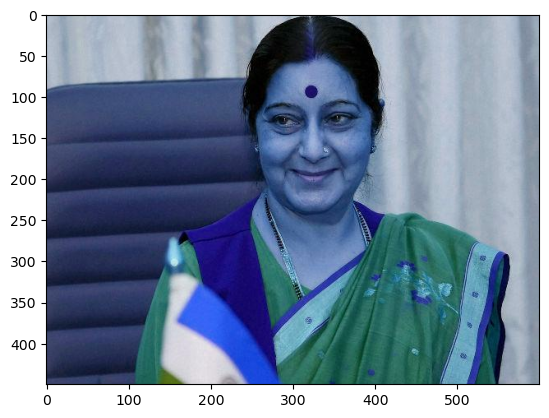

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(450, 600)

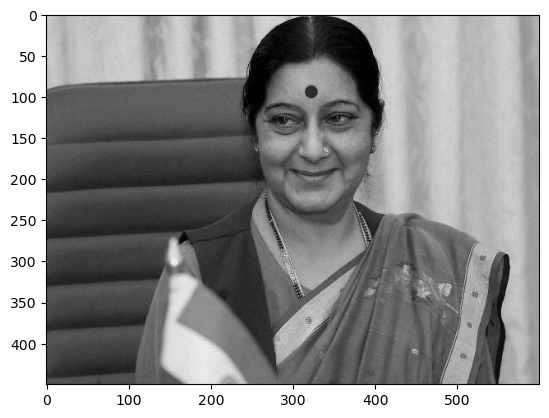

In [5]:
plt.imshow(gray, cmap='gray')

## We will use open cv document haarcascades for cascading purpose .##

In [6]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[236,  59, 184, 184]])

**We will store the eyes and front face cascades in rectangle boxes for that we need the variables.**

In [7]:
(a,b,w,h) = faces[0]
a,b,w,h

(236, 59, 184, 184)

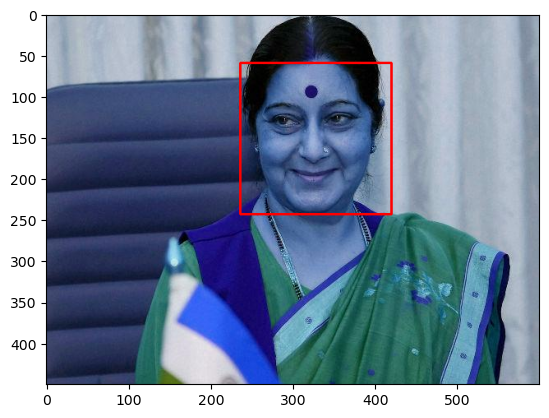

In [8]:
face_img = cv2.rectangle(img,(a,b),(a+w,b+h),(255,0,0),2)
plt.imshow(face_img)

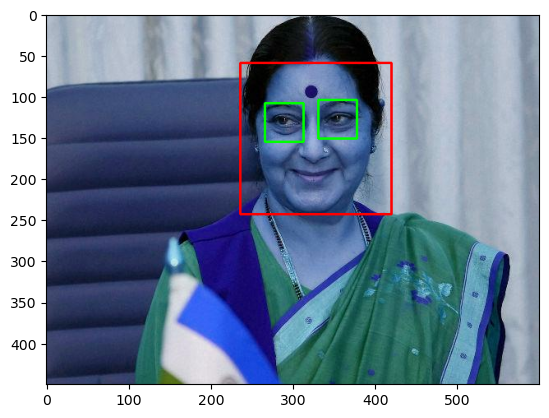

In [9]:
cv2.destroyAllWindows()
for (a,b,w,h) in faces:
    face_img = cv2.rectangle(img,(a,b),(a+w,b+h),(255,0,0),2)
    roi_gray = gray[b:b+h, a:a+w]
    roi_color = face_img[b:b+h, a:a+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ea,eb,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ea,eb),(ea+ew,eb+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

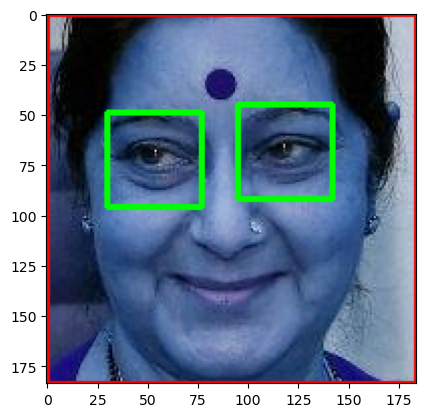

In [10]:
plt.imshow(roi_color, cmap = 'gray')

**Now we will make a function where we will get the cropped images for all the images that we rerquire for the classification.**

In [11]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (a,b,w,h) in faces:
        roi_gray = gray[b:b+h, a:a+w]
        roi_color = img[b:b+h, a:a+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

for example

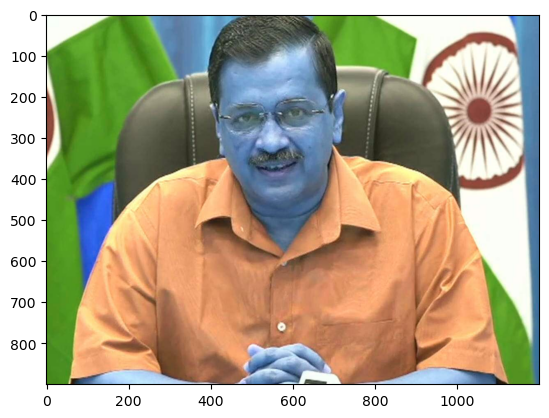

In [12]:
original_image = cv2.imread("./datasets/arvind kejriwal images - Google Search/81783837.jpg")
plt.imshow(original_image)

**Now lets see if we get the cropped image for this one or not.**

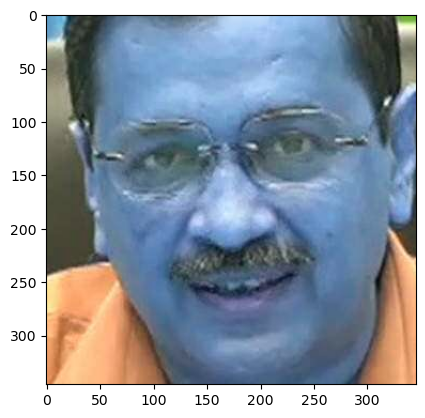

In [13]:
cropped_image = get_cropped_image_if_2_eyes("./datasets/arvind kejriwal images - Google Search/81783837.jpg")
plt.imshow(cropped_image)

**So here we get the cropped image as per depending feature on face and eyes.**

## Since this is a clear view of face and eyes that's why we are getting cropped image , obstructed images will not give the desired result. ##

In [14]:
path_to_data = "./datasets/"
path_to_cropped_data = "./datasets/cropped/"

## To make it easy we will use python os list to store the paths of all sub-folders .##

In [15]:
import os
img_directories = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_directories.append(entry.path)

In [16]:
img_directories

['./datasets/arvind kejriwal images - Google Search',
 './datasets/atal bihari vajpayee images - Google Search',
 './datasets/sushma swaraj images - Google Search']

**To make a cropped folder or if it is already made then to remove it we will import shutil.**

In [17]:
import shutil
if os.path.exists(path_to_cropped_data):
     shutil.rmtree(path_to_cropped_data)
os.mkdir(path_to_cropped_data)

In [18]:
cropped_image_directories = []
celebrity_file_names_dictonary = {}

for img_dir in img_directories:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dictonary[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cropped_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_directories.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dictonary[celebrity_name].append(cropped_file_path)
            count += 1  

arvind kejriwal images - Google Search
Generating cropped images in folder:  ./datasets/cropped/arvind kejriwal images - Google Search
atal bihari vajpayee images - Google Search
Generating cropped images in folder:  ./datasets/cropped/atal bihari vajpayee images - Google Search
sushma swaraj images - Google Search
Generating cropped images in folder:  ./datasets/cropped/sushma swaraj images - Google Search


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## Now we will use wavelet transform as a feature to train our future model. ##

**In wavelet transformed images , edges are so fine that can give us various facial features like eyes, nose, lips, etc.**

**For that we will import wavelet documentation as pywt .**

In [19]:
import pywt

In [20]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

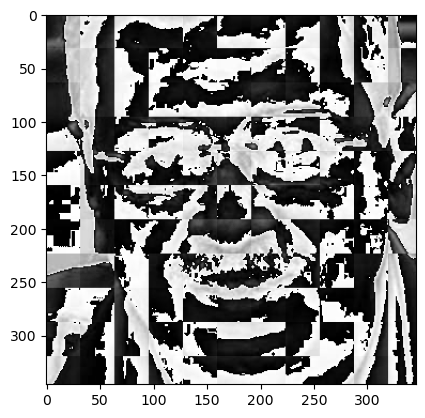

In [21]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [22]:
celebrity_file_names_dictonary

{'arvind kejriwal images - Google Search': ['./datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search1.png',
  './datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search2.png',
  './datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search3.png',
  './datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search4.png',
  './datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search5.png',
  './datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search6.png',
  './datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search7.png',
  './datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search8.png',
  './datasets/cropped/arvind kejriwal images - Google Search/arvind kejriwal images - Google Search9.p

In [23]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dictonary.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'arvind kejriwal images - Google Search': 0,
 'atal bihari vajpayee images - Google Search': 1,
 'sushma swaraj images - Google Search': 2}

In [24]:
X = []
y = []

for celebrity_name, training_files in celebrity_file_names_dictonary.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name]) 

In [25]:
len(X)

137

In [26]:
len(y)

137

In [27]:
len(X[0])

4096

In [28]:
X[0]

array([[ 63],
       [ 54],
       [ 50],
       ...,
       [103],
       [105],
       [106]], dtype=uint8)

In [29]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(137, 4096)

In [30]:
X[0]

array([ 63.,  54.,  50., ..., 103., 105., 106.])

## Data cleaning and preprocessing is done . So now we will train our model.
## Since this is a classification problem we will use Support Vector Machine(SVM). ##

In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9714285714285714

In [33]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00         7
           2       1.00      0.88      0.93         8

    accuracy                           0.97        35
   macro avg       0.98      0.96      0.97        35
weighted avg       0.97      0.97      0.97        35



## It was first model score , new lets check for more models .##

**We will use Grid Search HyperTuning for this.**

In [34]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [35]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [36]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.970000,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.852857,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.930476,{'logisticregression__C': 1}


In [37]:
 best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [38]:
 best_estimators['svm'].score(X_test, y_test)

1.0

In [39]:
 best_estimators['random_forest'].score(X_test, y_test)

0.9428571428571428

In [40]:
 best_estimators['logistic_regression'].score(X_test, y_test)

1.0

**So it is clear that logistic regression and svm is giving us the best scores .**

**We will use confusion matrix for this visulaisation.**

In [41]:
best_clf = best_estimators['svm']

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[20,  0,  0],
       [ 0,  7,  0],
       [ 0,  0,  8]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

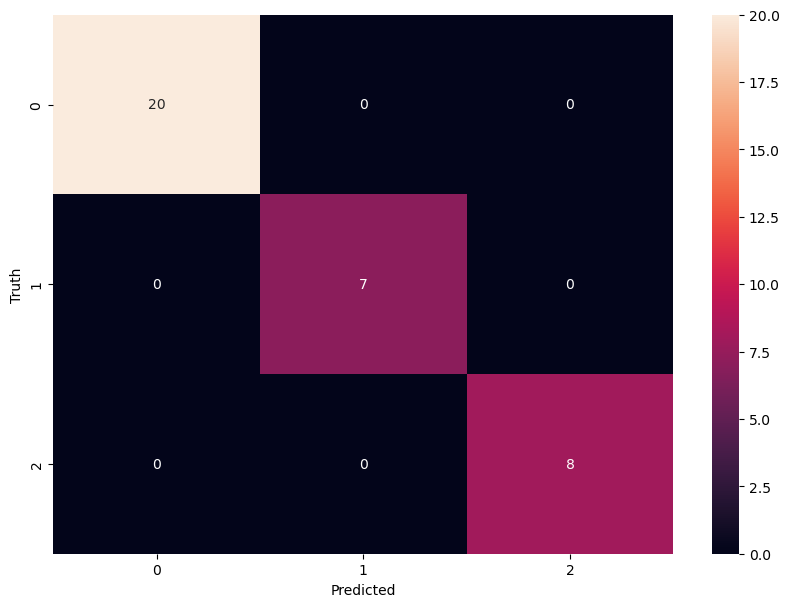

In [43]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

**Now we will save our model using joblib.**

In [44]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

**And we will save class our cklass dictonary for future python flask server.**

In [45]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))